## Now we have a bunch of neural data again. let's analyze it 

In [1171]:
import numpy as np
from numpy import random as rnd
import scipy.io as sio
from itertools import product
import seaborn as sns
import pandas as pd
import datetime
import pytz
import os
from numba import jit

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from scipy.stats import zscore
import scipy.stats as stats
import random
import scipy.io as sio

# from our files 
from tasks import PPSSM_FilteringTask
from models import RecurrentModel 
from visualizations import peaksort_vis_trial,forceAspect
from model_utils import save_model,load_model
from pp_init import pp_params

import numpy as np
import scipy.sparse as sps

import matplotlib.pyplot as plt

from pyglmnet import GLM, GLMCV,simulate_glm, datasets
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


### Trying out the pyglmnet package

In [17]:
n_samples, n_features = 1000, 100
distr = 'poisson'

# sample a sparse model
beta0 = np.random.normal(0.0, 1.0, 1)[0]
beta = sps.rand(n_features, 1, 0.1)
beta = np.squeeze(np.array(beta.todense()))

# simulate data
Xtrain = np.random.normal(0.0, 1.0, [n_samples, n_features])
ytrain = simulate_glm('poisson', beta0, beta, Xtrain) # [:, 0]
Xtest = np.random.normal(0.0, 1.0, [n_samples, n_features])
ytest = simulate_glm('poisson', beta0, beta, Xtest) # [:, 0]

# create an instance of the GLM class
# alpha = 1 is LASSO
glm = GLM(distr='poisson', score_metric='deviance',alpha = 0,reg_lambda = .1)

# fit the model on the training data
glm.fit(Xtrain, ytrain)

# predict using fitted model on the test data
yhat = glm.predict(Xtest)

# score the model on test data
deviance = glm.score(Xtest, ytest)

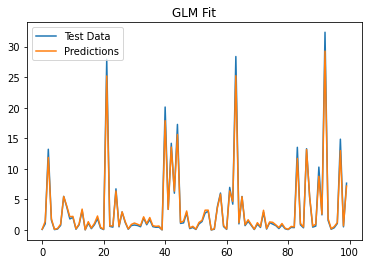

In [19]:
# visualize predictions
plt.plot(ytest[:100],label = "Test Data")
plt.plot(yhat[:100],label = "Predictions")
plt.title("GLM Fit")
plt.legend()
plt.show()

### First, make a GLM for RNNs

__Coefficients:__ 
- patch stop kernels (raised cosine basis)
- time since reward kernels (raised cosine basis)
- time on patch 
- time since reward 
- reward count

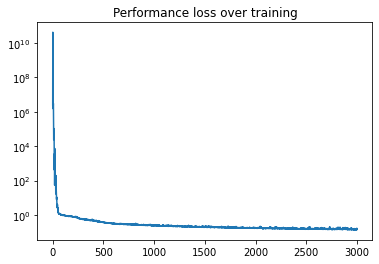

In [20]:
# load a model
load_path = '/Users/joshstern/Documents/am231/FinalProject/runs/04_22/16_43_offdiag=0.15_diag=0.98_sigma2eps=0.04.pt'
trained_model,train_params = load_model(load_path)
performance_losses = train_params['performance_losses']

# plot losses
plt.plot(performance_losses)
plt.yscale("log")
plt.title("Performance loss over training"); 


In [24]:
# Now run trained model on new environment
n_batches = 1 
test_task_params = pp_params("stochastic_foraging_session")
test_n_trials_per_tt = 10
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (example_input, example_output, opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        output_dict = trained_model.forward(example_input) # perform forward pass
        

In [1046]:
# Also RX environment 
n_batches = 1 
test_task_params = pp_params("rewtimes_foraging_session")
test_task_params['generation_params']['rewseqs'] = [np.array([0]),np.array([0,1])]
test_task_params['generation_params']['rewsizes'] = [1,2,4]
test_n_trials_per_tt = 200
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (rx_example_input, rx_example_output, rx_opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        rx_output_dict = trained_model.forward(rx_example_input) # perform forward pass
        

In [866]:
# Also RXX environment 
n_batches = 1 
test_task_params = pp_params("rewtimes_foraging_session")
test_n_trials_per_tt = 50
test_task_params['generation_params']['n_trials_per_tt'] = test_n_trials_per_tt # incr number of trials 
test_task = PPSSM_FilteringTask(test_task_params,max_iter = n_batches)
trained_model.batch_size = test_task.batch_size

# Run model on test trials 
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
with torch.no_grad():
    for i, (rxx_example_input, rxx_example_output, rxx_opt_s , opt_s_sigma2) in test_task: # loop over batches in training set 
        rxx_output_dict = trained_model.forward(rxx_example_input) # perform forward pass
        

In [25]:
# ok, sizes check out 
print('Neural data shape: ',output_dict['core_output'].shape)
print('Stimulus data shape:',example_output.shape)

Neural data shape:  torch.Size([90, 200, 500])
Stimulus data shape: torch.Size([90, 200, 1])


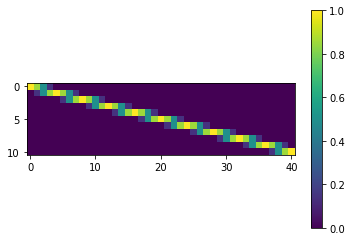

In [194]:
# basis functions for time since reward
nbasis_rew = 11  #  number of raised cosine basis functions to use
basis_length_rew = 2 # in seconds; make sure basis functions divide evenly into 1 second intervals (makes analysis easier)
cut_off_prev_after_rew = True
include_first_rew = True
dt = 0.05
t_basis_rew = np.arange(0,basis_length_rew + dt,dt)
db = (max(t_basis_rew) - min(t_basis_rew)) / (nbasis_rew-1)
c = np.arange(min(t_basis_rew),max(t_basis_rew) + db,db) # centers
bas_rew = np.zeros((nbasis_rew,len(t_basis_rew)))
for k in range(nbasis_rew):
    bas_rew[k,:] = (np.cos(np.maximum(-np.pi, np.minimum(np.pi,np.pi * (t_basis_rew - c[k]) / db))) + 1) / 2;

# same for patch stop
nbasis_patch_stop = 6  #  number of raised cosine basis functions to use
basis_length_patch_stop = 1 # in seconds; make sure basis functions divide evenly into 1 second intervals (makes analysis easier)
# we cut off the sequence of kernels when a new reward arrives
# we include first reward in reward kernels
t_basis_patch_stop = np.arange(0,basis_length_patch_stop + dt,dt)
db = (max(t_basis_patch_stop) - min(t_basis_patch_stop)) / (nbasis_patch_stop-1)
c = np.arange(min(t_basis_patch_stop),max(t_basis_patch_stop) + db,db) # centers
bas_patch_stop = np.zeros((nbasis_patch_stop,len(t_basis_patch_stop)))
for k in range(nbasis_patch_stop):
    bas_patch_stop[k,:] = (np.cos(np.maximum(-np.pi, np.minimum(np.pi,np.pi * (t_basis_patch_stop - c[k]) / db))) + 1) / 2;

plt.figure()   
plt.imshow(bas_rew)
plt.colorbar()



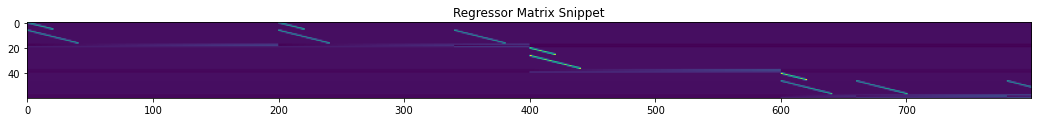

In [310]:
# now make function to map example_output (the reward sequences) to regressors 
trial_rews = example_output.squeeze().numpy()
n_trials = trial_rews.shape[0]
t_len = trial_rews.shape[1]

# a bit of sneaky stuff to get the reward times
trials,rewards = np.where(trial_rews == 1)
trials = trials[rewards % 10 == 0] #  just use the reward onset
rewards = rewards[rewards % 10 == 0] # just use the reward onset

# first get reward size
rewsize = np.zeros(n_trials)
rewsize[trial_rews[:,0] == 1] = 1
rewsize[trial_rews[:,1] == 1] = 2
rewsize[trial_rews[:,3] == 1] = 4
n_regressors = 3 * (nbasis_rew + nbasis_patch_stop + 3)
n_regressors_per = (nbasis_rew + nbasis_patch_stop + 3)

X = []

time_on_patch = np.arange(0,dt * t_len,dt)
for i_trial in range(n_trials):
    trial_X_unpadded = np.zeros((nbasis_patch_stop + nbasis_rew + 3,t_len))
    
    # convolve with basis functions
    rew_binary = np.zeros(t_len)
    if include_first_rew == True:
        rew_binary[rewards[trials == i_trial]] = 1
    else: 
        rew_binary[rewards[trials == i_trial] & rewards[trials == i_trial] > 0] = 1
    rew_conv = np.zeros((nbasis_rew,t_len))
    for i_kernel in range(nbasis_rew): 
        conv_this = np.convolve(rew_binary,bas_rew[i_kernel,:])
        rew_conv[i_kernel,:] = conv_this[:t_len]
    # cut off after rewards
    if cut_off_prev_after_rew == True:
        idx = np.argmax(rew_conv > 0,axis = 0)
        for t in range(rew_conv.shape[1]):
            rew_conv[idx[t]+2:,t] = 0
    # add kernel coefficients to unpadded trial X 
    trial_X_unpadded[:nbasis_patch_stop,:bas_patch_stop.shape[1]] = bas_patch_stop
    trial_X_unpadded[nbasis_patch_stop:nbasis_patch_stop + nbasis_rew,:] = rew_conv
    
    # Now add decision variables
    trial_rewtimes = rewards[trials == i_trial]
    trial_time_since_rew = np.arange(0,dt * t_len,dt)
    trial_reward_count = np.zeros(t_len)
    for i_rew_time in trial_rewtimes: 
        trial_time_since_rew[i_rew_time:] = np.arange(0,dt * (t_len - i_rew_time),dt)
        trial_reward_count[i_rew_time:] = 1 + trial_reward_count[i_rew_time-1]
    trial_X_unpadded[-3,:] = time_on_patch
    trial_X_unpadded[-2,:] = trial_time_since_rew
    trial_X_unpadded[-1,:] = trial_reward_count
    
    # last,pad based on reward size
    trial_X_padded = np.zeros((n_regressors,t_len))
    if rewsize[i_trial] == 1:
        trial_X_padded[:n_regressors_per,:] = trial_X_unpadded
    elif rewsize[i_trial] == 2:
        trial_X_padded[n_regressors_per:2*n_regressors_per,:] = trial_X_unpadded
    elif rewsize[i_trial] == 4:
        trial_X_padded[2*n_regressors_per:,:] = trial_X_unpadded
    X.append(trial_X_padded)
    
# Visualize a bit of the matrix
X_concat = np.concatenate([X[trial] for trial in [0,20,40,88]],axis = 1)
plt.figure(figsize = (18,30))
plt.imshow(zscore(X_concat[:,:800],axis = 1))
plt.title("Regressor Matrix Snippet")
plt.show()
X_full = np.concatenate(X,axis = 1)


array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,
        3,  3,  3,  4,  4,  4,  4,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,
        2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9])

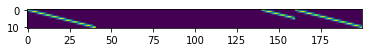

In [180]:
plt.imshow(rew_conv)
# rew_binary
idx = np.argmax(rew_conv > 0,axis = 0)
for t in range(rew_conv.shape[1]):
    rew_conv[idx[t]+2:,t] = 0
plt.imshow(rew_conv)
idx

In [486]:
# apply FR cutoff? 
min_fr = 1

# apply firing rate cutoff
FR = output_dict['core_output'].squeeze().numpy().T
n_neurons = FR.shape[0]
FR_full = FR.reshape(n_neurons,t_len * n_trials,order = 'F')
mean_FR = np.mean(FR_full,axis = 1) / dt
keep_cell = mean_FR > min_fr
FR = FR.swapaxes(0,1).T
FR = FR[:,keep_cell,:]
n_good_cells = FR.shape[1]

# make FR list for compatibili
# FR = output_dict['core_output'].squeeze().numpy().T

(500, 18000)

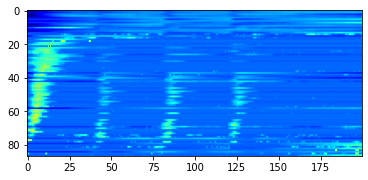

In [569]:
trial = 83
peaksort = peaksort_vis_trial(output_dict['core_output'][trial][:,keep_cell],sort_end_ix = 20,normalization = 'zscore')


In [374]:
# Check dimensions
print(X_full.shape)
print(FR.shape)


(60, 18000)
(493, 200)


In [489]:
# assign folds for xval
xval_fold = np.zeros(n_trials);
n_folds = 5
shift_by = 0 # to make sure equal numbers of trials end up in each fold
for i_rewsize in range(3):
    keep_this = np.minimum(3,rewsize) == i_rewsize + 1
    xval_fold[keep_this] = np.tile(np.arange(n_folds),int(np.ceil(sum(keep_this)/n_folds)*n_folds))[:sum(keep_this)]
    shift_by = shift_by - sum(keep_this) % n_folds


In [578]:
# GLM fitting procedure 1
alpha = 0.9
reg_lambda = 0.01

fit_glms = []

regressor_means = np.mean(X_full,axis = 1)
regressor_stds = np.std(X_full,axis = 1)

deviances_no_lambda_opt = np.zeros(n_good_cells)

# iterate over cells
for i_cell in range(n_good_cells):
    # fit the model on the training data
    fold_deviance = np.zeros(n_folds)
    for i_fold in range(n_folds): 
        # train
        train_trials = np.where(xval_fold != i_fold)[0]
        X_train = (np.concatenate([X[i_trial] for i_trial in train_trials],axis = 1).T - regressor_means) / regressor_stds
        y_train = np.concatenate([FR[i_trial][i_cell,:] for i_trial in train_trials])
        
#         fold_glm = GLMCV(distr='poisson', score_metric='deviance',alpha = alpha,cv = 5)
        fold_glm = GLM(distr='poisson', score_metric='deviance',alpha = alpha,reg_lambda = reg_lambda)
        fold_glm.fit(X_train, y_train)
        
        # predict on test set
        test_trials = np.where(xval_fold != i_fold)[0]
        X_test = (np.concatenate([X[i_trial] for i_trial in test_trials],axis = 1).T - regressor_means) / regressor_stds
        y_test = np.concatenate([FR[i_trial][i_cell,:] for i_trial in test_trials])
        y_hat = fold_glm.predict(X_test)
        fold_deviance[i_fold] = fold_glm.score(X_test, y_test)
        
    # calculate deviance on test data
    deviances_no_lambda_opt[i_cell] = np.mean(fold_deviance)
    
    print("Cell %i complete"%i_cell)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


Cell 0 complete
Cell 1 complete
Cell 2 complete
Cell 3 complete
Cell 4 complete
Cell 5 complete
Cell 6 complete
Cell 7 complete


KeyboardInterrupt: 

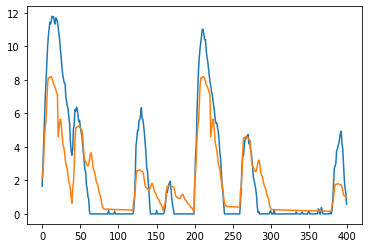

In [556]:
# Plot over test data 
plt.plot(y_test[(70 * t_len):(83 * t_len)])
plt.plot(y_hat[(70 * t_len):(83 * t_len)])


In [574]:
# GLM fitting procedure 2
X_full_norm = (X_full.T - regressor_means)/regressor_stds
alpha = 0.9
n_reg_lambdas = 10
reg_lambdas = np.logspace(np.log(0.5), np.log(0.01), n_reg_lambdas, base=np.exp(1))

fit_glms = []

regressor_means = np.mean(X_full,axis = 1)
regressor_stds = np.std(X_full,axis = 1)

deviances = np.zeros(n_good_cells)
lambda_opts = np.zeros(n_good_cells)
y_hat_full = np.zeros((n_good_cells,X_full.shape[1]))
beta = np.zeros((n_regressors,n_good_cells))

# iterate over cells
for i_cell in range(n_good_cells):
    # iterate over regularization lambdas 
    lambda_deviance = np.zeros(len(reg_lambdas))
    for i_lambda,reg_lambda in enumerate(reg_lambdas): 
        # fit the model on the training data
        fold_deviance = np.zeros(n_folds)
        for i_fold in range(n_folds): 
            # train
            train_trials = np.where(xval_fold != i_fold)[0]
            X_train = (np.concatenate([X[i_trial] for i_trial in train_trials],axis = 1).T - regressor_means) / regressor_stds
            y_train = np.concatenate([FR[i_trial][i_cell,:] for i_trial in train_trials])

            fold_glm = GLM(distr='poisson', score_metric='deviance',alpha = alpha,reg_lambda = reg_lambda)
            fold_glm.fit(X_train, y_train)
    
            # predict on test set
            test_trials = np.where(xval_fold != i_fold)[0]
            X_test = (np.concatenate([X[i_trial] for i_trial in test_trials],axis = 1).T - regressor_means) / regressor_stds
            y_test = np.concatenate([FR[i_trial][i_cell,:] for i_trial in test_trials])
            fold_deviance[i_fold] = fold_glm.score(X_test, y_test)
        
        lambda_deviance[i_lambda] = np.mean(fold_deviance)
    
    # Now fit GLM using optimal regularization value on full session data  
    lambda_opts[i_cell] = reg_lambdas[np.argmin(lambda_deviance)]
    y_full = np.concatenate([FR[i_trial][i_cell,:] for i_trial in range(n_trials)])
    opt_glm = GLM(distr='poisson', score_metric='deviance',alpha = alpha,reg_lambda = lambda_opts[i_cell])
    opt_glm.fit(X_full_norm,y_full)
    this_y_hat = opt_glm.predict(X_full_norm)
    y_hat_full[i_cell,:] = this_y_hat
    
    # calculate deviance on test data
    deviances[i_cell] = opt_glm.score(X_full_norm,y_full)
    beta[:,i_cell] = opt_glm.beta_
    
    print("Cell %i complete"%i_cell)


Cell 0 complete
Cell 1 complete
Cell 2 complete
Cell 3 complete
Cell 4 complete
Cell 5 complete
Cell 6 complete
Cell 7 complete
Cell 8 complete
Cell 9 complete
Cell 10 complete
Cell 11 complete
Cell 12 complete
Cell 13 complete
Cell 14 complete
Cell 15 complete
Cell 16 complete
Cell 17 complete
Cell 18 complete
Cell 19 complete
Cell 20 complete
Cell 21 complete
Cell 22 complete
Cell 23 complete
Cell 24 complete
Cell 25 complete
Cell 26 complete
Cell 27 complete
Cell 28 complete
Cell 29 complete
Cell 30 complete
Cell 31 complete
Cell 32 complete
Cell 33 complete
Cell 34 complete
Cell 35 complete
Cell 36 complete
Cell 37 complete
Cell 38 complete
Cell 39 complete
Cell 40 complete
Cell 41 complete
Cell 42 complete
Cell 43 complete
Cell 44 complete
Cell 45 complete
Cell 46 complete
Cell 47 complete
Cell 48 complete
Cell 49 complete
Cell 50 complete
Cell 51 complete
Cell 52 complete
Cell 53 complete
Cell 54 complete
Cell 55 complete
Cell 56 complete
Cell 57 complete
Cell 58 complete
Cell 59

(array([75.,  1.,  4.,  0.,  3.,  0.,  2.,  0.,  0.,  2.]),
 array([0.01      , 0.04137394, 0.07274788, 0.10412182, 0.13549576,
        0.1668697 , 0.19824364, 0.22961758, 0.26099152, 0.29236546,
        0.3237394 ]),
 <a list of 10 Patch objects>)

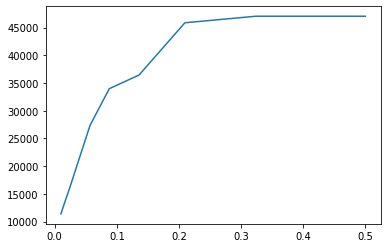

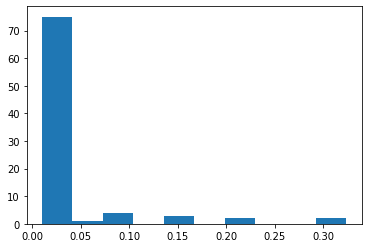

In [579]:
plt.plot(reg_lambdas,lambda_deviance)
reg_lambda_opt = reg_lambdas[np.argmin(lambda_deviance)] 
reg_lambda_opt
plt.figure()
plt.hist(lambda_opts)

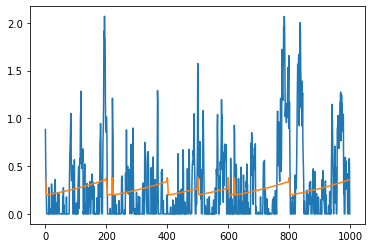

In [630]:
cell = 2
y_full = np.concatenate([FR[i_trial] for i_trial in range(n_trials)],axis = 1)
plt.plot(y_full[cell,:1000])
plt.plot(y_hat_full[cell,:1000])

In [752]:
def beta_visualization(beta_vec,nbasis_patch_stop,nbasis_rew,regressor_names,ax = None): 
    """ 
        Visualize GLM coefficients for a vector of beta coefficients
    """
    cool3 = sns.color_palette('cool',3)
    n_regressors_per = nbasis_patch_stop + nbasis_rew + 3
    if ax: 
        # patchstop kernels
        patchstop_x = np.arange(nbasis_patch_stop)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL patchstop kern"%i_rewsize) >= 0 for k in range(n_regressors)])
            ax.plot(patchstop_x,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)],linewidth = 2)
        # reward kernels
        rew_x = np.arange(nbasis_patch_stop,nbasis_patch_stop + nbasis_rew)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL rew kern"%i_rewsize) >= 0 for k in range(n_regressors)])
            ax.plot(rew_x,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)],linewidth = 2)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL time_on_patch"%i_rewsize) >= 0 for k in range(n_regressors)])
            ax.scatter(max(rew_x) + 1,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)])
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL time_since_rew"%i_rewsize) >= 0 for k in range(n_regressors)])
            ax.scatter(max(rew_x) + 2,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)]) 
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL total_rew"%i_rewsize) >= 0 for k in range(n_regressors)])
            ax.scatter(max(rew_x) + 3,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)]) 
    else: 
        # patchstop kernels
        patchstop_x = np.arange(nbasis_patch_stop)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL patchstop kern"%i_rewsize) >= 0 for k in range(n_regressors)])
            plt.plot(patchstop_x,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)],linewidth = 2)
        # reward kernels
        rew_x = np.arange(nbasis_patch_stop,nbasis_patch_stop + nbasis_rew)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL rew kern"%i_rewsize) >= 0 for k in range(n_regressors)])
            plt.plot(rew_x,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)],linewidth = 2)
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL time_on_patch"%i_rewsize) >= 0 for k in range(n_regressors)])
            plt.scatter(max(rew_x) + 1,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)])
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL time_since_rew"%i_rewsize) >= 0 for k in range(n_regressors)])
            plt.scatter(max(rew_x) + 2,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)]) 
        for i_rewsize in [1,2,4]:
            these_coeffs = np.array([regressor_names[k].find("%iuL total_rew"%i_rewsize) >= 0 for k in range(n_regressors)])
            plt.scatter(max(rew_x) + 3,beta_vec[these_coeffs],color = cool3[min(2,i_rewsize-1)]) 
            

Text(0.5, 0.92, 'Projections onto coefficient PC space')

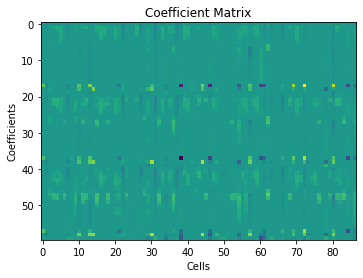

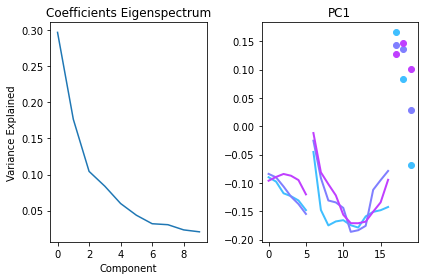

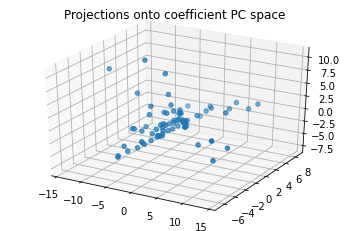

In [817]:
# visualize coefficients and eigenspectrum
regressor_names = []
for i_rewsize in [1,2,4]:
    regressor_names = regressor_names + ["%iuL patchstop kern %i"%(i_rewsize,i) for i in range(nbasis_patch_stop)]
    regressor_names = regressor_names + ["%iuL rew kern %i"%(i_rewsize,i) for i in range(nbasis_rew)]
    regressor_names = regressor_names + ["%iuL time_on_patch"%i_rewsize] + ["%iuL time_since_rew"%i_rewsize] + ["%iuL total_rew"%i_rewsize]

plt.figure()
plt.imshow(beta)
plt.title("Coefficient Matrix");
plt.xlabel("Cells")
plt.ylabel("Coefficients")

beta_norm = zscore(beta.T)

beta_pca = PCA(n_components=10)
beta_pca.fit(beta_norm)

fig,ax = plt.subplots(1,2)
ax[0].set_title("Coefficients Eigenspectrum")
ax[0].set_ylabel("Variance Explained")
ax[0].set_xlabel("Component")
ax[0].plot(beta_pca.explained_variance_ratio_)
beta_visualization(beta_pca.components_[0,:],nbasis_patch_stop,nbasis_rew,regressor_names,ax = ax[1])
ax[1].set_title("PC1")
fig.tight_layout()

score = beta_pca.transform(beta_norm)

fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(beta_pca.transform(beta_norm)[:,0],beta_pca.transform(beta_norm)[:,1],beta_pca.transform(beta_norm)[:,2])
ax3d.set_title("Projections onto coefficient PC space")



Text(0.5, 0, 'Number of Clusters')

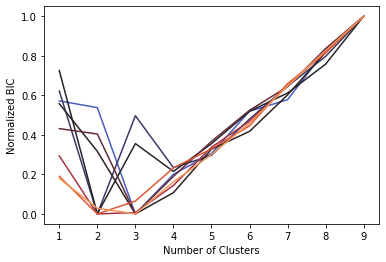

In [851]:
# Cluster cells in coefficient space
max_clusters = 10
max_pcs = 10
cmap = sns.color_palette('icefire',max_pcs)
for n_pcs in range(2,max_pcs):
    bic = np.zeros(max_clusters-1)
    for n_clusters in range(1,max_clusters):
        gm = GaussianMixture(n_components=n_clusters, random_state=0,reg_covar=1.).fit(score[:,:n_pcs])
        bic[n_clusters-1] = gm.bic(score[:,:n_pcs])
    plt.plot(list(range(1,max_clusters)),(bic - max(bic))/(max(bic) - min(bic))+1,color = cmap[n_pcs])
plt.ylabel("Normalized BIC")
plt.xlabel("Number of Clusters")

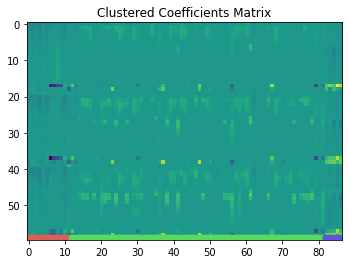

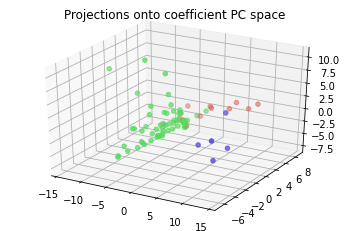

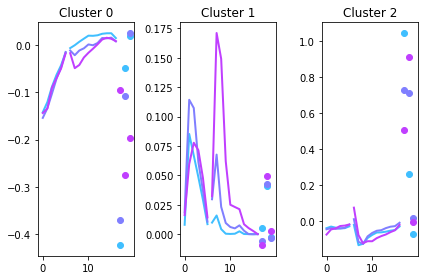

In [1008]:
from matplotlib.colors import ListedColormap

cluster_cmap = ListedColormap(sns.color_palette("hls",3).as_hex())
cluster_cmap_list = sns.color_palette("hls",3)

# Cluster coefficients w/ 3 clusters
n_clusters = 3
reduced_beta = beta_pca.components_[:,:5]
cluster_ix = GaussianMixture(n_components=n_clusters, random_state=0,reg_covar=.35).fit_predict(score[:,:4])

# visualized clustered beta matrix
beta_sorted = []
cluster_sorted = []
for i_cluster in range(n_clusters):
    cluster_neurons = np.where(cluster_ix == i_cluster)[0]
    cluster_sorted.append(np.full(len(cluster_neurons),i_cluster))
    beta_sorted.append(beta[:,cluster_neurons])
beta_sorted = np.concatenate(beta_sorted,axis = 1)
cluster_sorted = np.concatenate(cluster_sorted)
plt.figure()
plt.imshow(beta_sorted)
plt.scatter(np.arange(len(cluster_sorted)),np.full(len(cluster_sorted),beta_sorted.shape[0])-1,c = cluster_sorted,cmap=cluster_cmap)
plt.title("Clustered Coefficients Matrix")

# visualize clusters in PC space
fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(score[:,0],score[:,1],score[:,2],c = cluster_ix,cmap=cluster_cmap)
ax3d.set_title("Projections onto coefficient PC space")

fig,ax = plt.subplots(1,n_clusters)
for i_cluster in range(n_clusters):
    cluster_mean_beta = np.mean(beta[:,cluster_ix == i_cluster],axis = 1)
    beta_visualization(cluster_mean_beta,nbasis_patch_stop,nbasis_rew,regressor_names,ax = ax[i_cluster])
    ax[i_cluster].set_title("Cluster %i"%i_cluster)
fig.tight_layout()

In [917]:
rx_output_dict['core_output'].numpy().shape

(300, 200, 500)

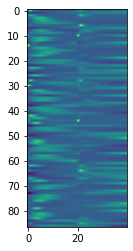

In [1047]:
# visualize mean activity on RX trials
rx_FR = rx_output_dict['core_output'].numpy()[:,:40,keep_cell] # first index is trials
tt_ranges = np.arange(0,test_n_trials_per_tt * 6 + test_n_trials_per_tt,test_n_trials_per_tt)
rx_FR_avgs = [np.mean(rx_FR[tt_ranges[i]:tt_ranges[i+1]],axis = 0).T for i in range(len(tt_ranges)-1)]
plt.imshow(zscore(rx_FR_avgs[3],axis = 1))


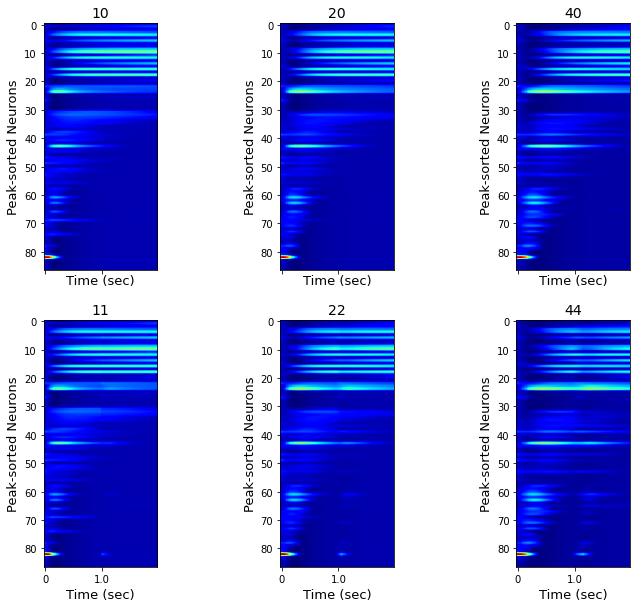

In [1048]:
# visualize peaksorted RX (BTW)
peaksort = np.flipud(np.argsort(np.argmax(rx_FR_avgs[3],axis = 1)))
tt_names = ["10","11","20","22","40","44"]
fig,ax = plt.subplots(2,3,figsize = (12,10),sharex = True)
for i_rewsize in range(3): 
    for i_cond in range(2):
        tt_ix = (i_rewsize) * 2 + i_cond
        ax[i_cond,i_rewsize].imshow(zscore(rx_FR_avgs[tt_ix][peaksort,:]),cmap = 'jet')
#         ax[i_cond,i_rewsize].imshow(rx_FR_avgs[tt_ix][peaksort,:] / np.max(rx_FR_avgs[tt_ix][peaksort,:],axis = 0),cmap = 'jet')
        ax[i_cond,i_rewsize].set_xlabel("Time (sec)",fontsize = 13)
        ax[i_cond,i_rewsize].set_xticks([0,20])
        ax[i_cond,i_rewsize].set_xticklabels([0,1.0])
        ax[i_cond,i_rewsize].set_title(tt_names[tt_ix],fontsize = 14)
        ax[i_cond,i_rewsize].set_ylabel("Peak-sorted Neurons",fontsize = 13)

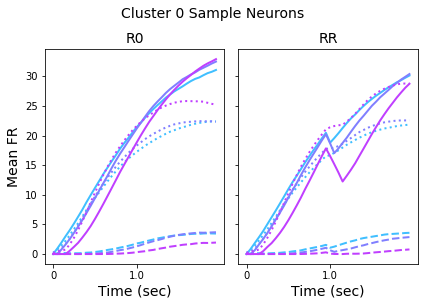

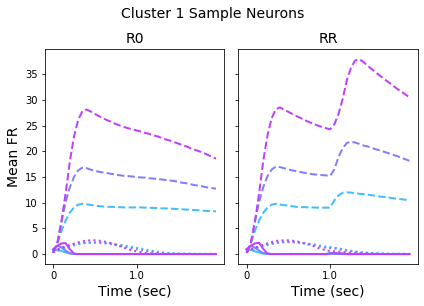

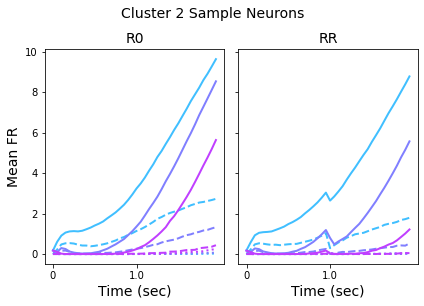

In [1065]:
# Visualize mean cluster activity per tt
cool3 = sns.color_palette('cool',3)
n_neurons_plot = 3
linestyles = [':','--','-']
conds = ["R0","RR"]
for i_cluster in range(3):
    cluster_neurons = np.where(cluster_ix == i_cluster)[0]
    n_cluster_neurons = len(cluster_neurons)
    neuron_sample_ix = random.sample(range(n_cluster_neurons),n_neurons_plot)
    fig,ax = plt.subplots(1,2,sharey = True)
    for i_cond in range(2): 
        for i_rewsize in range(3): 
            tt_ix = (i_rewsize) * 2 + i_cond
            for i_neuron in range(n_neurons_plot):
                ax[i_cond].plot(rx_FR_avgs[tt_ix][cluster_neurons[neuron_sample_ix[i_neuron]],:],color = cool3[i_rewsize],linewidth = 2,linestyle = linestyles[i_neuron])

            ax[i_cond].set_title(conds[i_cond],fontsize = 14)
            ax[i_cond].set_xlabel("Time (sec)",fontsize = 14)
            ax[i_cond].set_xticks([0,20])
            ax[i_cond].set_xticklabels([0,1.])

    ax[0].set_ylabel("Mean FR",fontsize = 14)
    fig.tight_layout()
    plt.suptitle("Cluster %i Sample Neurons"%i_cluster, y=1.05,fontsize = 14)



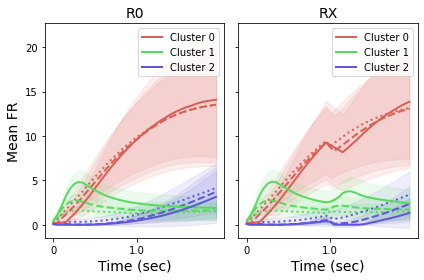

In [1072]:
# Visualize mean cluster activity per tt
fig,ax = plt.subplots(1,2,sharey = True)
linestyles = [':','--','-']
conds = ["R0","RX"]
for i_cond in range(2): 
    for i_rewsize in range(3): 
        tt_ix = (i_rewsize) * 2 + i_cond
        for i_cluster in range(n_clusters):
            cluster_neurons = np.where(cluster_ix == i_cluster)[0]
            n_cluster_neurons = len(cluster_neurons)
            
            cluster_tt_mean = np.mean(rx_FR_avgs[tt_ix][cluster_neurons,:],axis = 0)
            cluster_tt_sem = 1.96 * np.std(rx_FR_avgs[tt_ix][cluster_neurons,:],axis = 0) / np.sqrt(n_cluster_neurons)
            if i_rewsize == 2:
                ax[i_cond].plot(cluster_tt_mean,color = cluster_cmap_list[i_cluster],linewidth = 2,linestyle = linestyles[i_rewsize],label = "Cluster %i"%i_cluster)
            else: 
                ax[i_cond].plot(cluster_tt_mean,color = cluster_cmap_list[i_cluster],linewidth = 2,linestyle = linestyles[i_rewsize])
            ax[i_cond].fill_between(np.arange(40),cluster_tt_mean-cluster_tt_sem,cluster_tt_mean+cluster_tt_sem,color = cluster_cmap_list[i_cluster],alpha = .1)
            ax[i_cond].set_title(conds[i_cond],fontsize = 14)
            ax[i_cond].set_xlabel("Time (sec)",fontsize = 14)
            ax[i_cond].set_xticks([0,20])
            ax[i_cond].set_xticklabels([0,1.])
    ax[i_cond].legend()

ax[0].set_ylabel("Mean FR",fontsize = 14)
fig.tight_layout()

## Reward Peak Distribution Analysis

array([  0,  50, 100, 150, 200, 250, 300])

## Canonical Correlation Analysis

And state space analysis

reference:
https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/nn.4042

Use RXX trials, all mice all neurons (using RX cross days w/ PETH_Xdays

Compare to representational models; linear combination of task variables (1D)

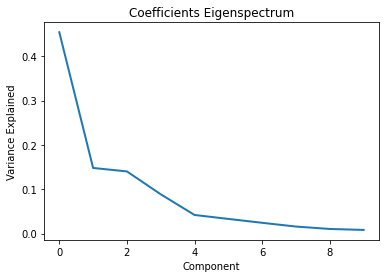

In [1133]:
# First plot PCA projections
rx_RF_avgs_full = np.concatenate(rx_FR_avgs,axis = 1)
rx_RF_avgs_full_norm = zscore(rx_RF_avgs_full,axis = 1)
rx_pca = PCA(n_components=10)
rx_pca.fit(rx_RF_avgs_full_norm.T)

fig,ax = plt.subplots(1,1)
ax.set_title("Coefficients Eigenspectrum")
ax.set_ylabel("Variance Explained")
ax.set_xlabel("Component")
ax.plot(rx_pca.explained_variance_ratio_,linewidth = 2)
rx_score = rx_pca.transform(rx_RF_avgs_full_norm.T)

tt_ranges = np.arange(0,40 * 6 + 40,40)
rx_score_tt = [rx_score[tt_ranges[i]:tt_ranges[i+1],:].T for i in range(len(tt_ranges)-1)]


Text(0.5, 0.98, 'PCA Trajectories')

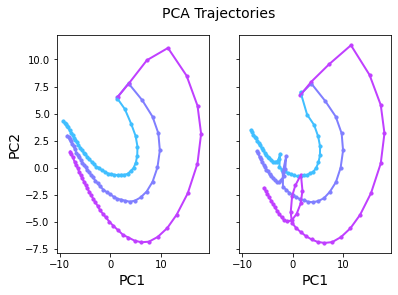

In [1251]:
fig,ax = plt.subplots(1,2,sharey = True,sharex = True)
# ax3d = fig3d.add_subplot(projection='3d')
for i_cond in range(2):
    for i_rewsize in range(3):
        tt_ix = (i_rewsize) * 2 + i_cond
        tt_score = rx_score_tt[tt_ix]
        for i_pc in range(1,2):
            ax[i_cond].scatter(tt_score[0,:],tt_score[i_pc,:],color = cool3[i_rewsize],s = 10)
            ax[i_cond].plot(tt_score[0,:],tt_score[i_pc,:],color = cool3[i_rewsize],linewidth = 2)
ax[0].set_xlabel("PC1",fontsize = 14)
ax[0].set_ylabel("PC2",fontsize = 14)
ax[1].set_xlabel("PC1",fontsize = 14)
fig.suptitle("PCA Trajectories",fontsize = 14)

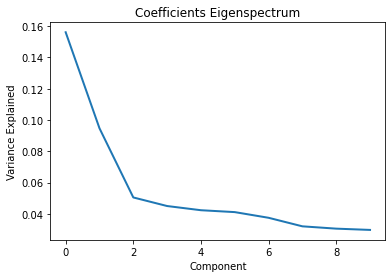

In [1254]:
import cv2
# load PFC data
rx_pfc_data_path = '/Users/joshstern/Documents/UchidaLab_NeuralData/patch_foraging_neuropix/josh/structs/RX_avgs_allPFC.mat'
rx_pfc_data = sio.loadmat(rx_pfc_data_path, squeeze_me=True )['RX_avgPETHs']

# resize to rnn timesteps
n_pfc_neurons = rx_pfc_data[0].shape[0]
rnn_t_len = rx_FR_avgs[0].shape[1]
rx_pfc_data = [cv2.resize(rx_pfc_data[k], dsize=(rnn_t_len,n_pfc_neurons), interpolation=cv2.INTER_NEAREST) for k in range(6)]

rx_pfc_data_full = np.concatenate(rx_pfc_data,axis = 1)
rx_pfc_data_full_norm = zscore(rx_pfc_data_full,axis = 1)

rx_pfc_pca = PCA(n_components=10)
rx_pfc_pca.fit(rx_pfc_data_full_norm.T)

fig,ax = plt.subplots(1,1)
ax.set_title("Coefficients Eigenspectrum")
ax.set_ylabel("Variance Explained")
ax.set_xlabel("Component")
ax.plot(rx_pfc_pca.explained_variance_ratio_,linewidth = 2)
rx_pfc_score = rx_pfc_pca.transform(rx_pfc_data_full_norm.T)

tt_ranges = np.arange(0,40 * 6 + 40,40)
rx_pfc_score_tt = [rx_pfc_score[tt_ranges[i]:tt_ranges[i+1],:].T for i in range(len(tt_ranges)-1)]



Text(0.5, 0.98, 'PCA Trajectories (PFC)')

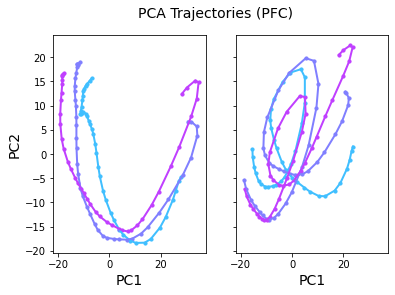

In [1255]:
fig,ax = plt.subplots(1,2,sharey = True,sharex = True)
# ax3d = fig3d.add_subplot(projection='3d')
for i_cond in range(2):
    for i_rewsize in range(3):
        tt_ix = (i_rewsize) * 2 + i_cond
        tt_score = rx_pfc_score_tt[tt_ix]
        for i_pc in range(1,2):
            ax[i_cond].scatter(tt_score[0,:],tt_score[i_pc,:],color = cool3[i_rewsize],s = 10)
            ax[i_cond].plot(tt_score[0,:],tt_score[i_pc,:],color = cool3[i_rewsize],linewidth = 2)
ax[0].set_xlabel("PC1",fontsize = 14)
ax[0].set_ylabel("PC2",fontsize = 14)
ax[1].set_xlabel("PC1",fontsize = 14)
fig.suptitle("PCA Trajectories (PFC)",fontsize = 14)

In [ ]:
## Now perform CCA 
# Note! this estimator can be unstable if the number of features or targets is greater than the number of samples.
# so maybe we should cut down the neurons used
